In [1]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0


In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location/pt1'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
#run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_ref = anndata.read_h5ad('/home/ssobti/projects/farnaz_spatial/data/new_ref/raw_ref.h5ad')

In [5]:
adata_ref.var

,_index,features
0,0610005C13Rik,0610005C13Rik
1,0610006L08Rik,0610006L08Rik
2,0610009B22Rik,0610009B22Rik
3,0610009E02Rik,0610009E02Rik
4,0610009O20Rik,0610009O20Rik
...,...,...
28722,Gm21778,Gm21778
28723,Gm28772,Gm28772
28724,Gm28972,Gm28972
28725,AC242269.1,AC242269.1


In [6]:
adata_ref.var.set_index('_index', drop=True, inplace=True)
adata_ref.var.index.name = None

In [7]:
adata_ref.var

,features
0610005C13Rik,0610005C13Rik
0610006L08Rik,0610006L08Rik
0610009B22Rik,0610009B22Rik
0610009E02Rik,0610009E02Rik
0610009O20Rik,0610009O20Rik
...,...
Gm21778,Gm21778
Gm28772,Gm28772
Gm28972,Gm28972
AC242269.1,AC242269.1


In [8]:
adata_ref.var['SYMBOL'] = adata_ref.var.index

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

## Reduce number of genes (discard low expressing)

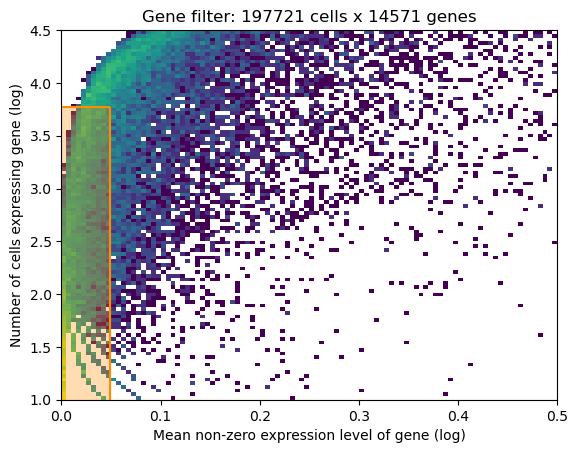

In [9]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [10]:
adata_ref.obs

,orig.ident,nCount_RNA,nFeature_RNA,name,species,technology,compartment,sample,tissue,depot,...,s.score,g2m.score,phase,integrated_snn_res.0.3,seurat_clusters,tree.ident,cell_type,cell_type2,ct3,predicted.celltype
Mm_ING_16-1_TCAAGCACACAGCGCT,Mm,130933.0,11061,Mm_ING_16-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_16,adipose,ING,...,-0.036499,-0.035362,G1,7,7,19,luminal_epithelial_HS,15,female_epithelial,1
Mm_ING_16-1_CCTCCAAGTATGGAAT,Mm,123909.0,11049,Mm_ING_16-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_16,adipose,ING,...,-0.049845,-0.029479,G1,7,7,19,luminal_epithelial_HS,15,female_epithelial,6
Mm_ING_16-1_TTCTTCCAGCAAGCCA,Mm,79931.0,9331,Mm_ING_16-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_16,adipose,ING,...,0.001394,-0.021315,S,7,7,19,luminal_epithelial_HS,15,female_epithelial,10
Mm_ING_16-1_CACCGTTTCCGCTGTT,Mm,77940.0,7926,Mm_ING_16-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_16,adipose,ING,...,0.008381,-0.021417,S,12,12,14,mAd3,0,mAd3,0
Mm_ING_16-1_AAACGCTCAACCTATG,Mm,74784.0,9440,Mm_ING_16-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_16,adipose,ING,...,0.055425,-0.024634,S,7,7,19,luminal_epithelial_HS,15,female_epithelial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mm_ING_11-1_GGTGAAGCAATACCCA,Mm,687.0,530,Mm_ING_11-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_11,adipose,ING,...,0.017934,-0.001514,S,16,16,9,mASPC5,1,preadipocyte,1
Mm_ING_11-1_CCCGAAGAGGTGGCTA,Mm,621.0,494,Mm_ING_11-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_11,adipose,ING,...,-0.011490,-0.014764,G1,3,3,10,mASPC2,1,preadipocyte,1
Mm_ING_11-1_ACTGATGAGTTCCAGT,Mm,557.0,420,Mm_ING_11-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_11,adipose,ING,...,0.019507,0.038628,G2M,3,3,10,mASPC2,1,preadipocyte,1
Mm_ING_11-1_GATAGAAAGAGTCCGA,Mm,485.0,355,Mm_ING_11-1,Mus musculus,Chromium-v3,nucleus,Mm_ING_11,adipose,ING,...,-0.006384,-0.006454,G1,3,3,10,mASPC2,1,preadipocyte,1


## Estimating expression signatures

In [11]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=None
                       )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   24   │
│         n_cells          │ 197721 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   48   │
│          n_vars          │ 14571  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ Mm_EPI_10  │          0          │
│                     │ Mm_EPI_11  │          1          │
│                     │ Mm_EPI_12  │          2          │
│                     │ Mm_EPI_13  │          3          │
│                     │ Mm_EPI_14  │          4          │
│                     │ Mm_EPI_17  │          5          │
│                     │ Mm_EPI_18  │          6          │
│                     │ Mm_EPI_19  │          7          │
│                     │ Mm_ING_08  │          8          │
│                     │ Mm_ING_09  │          9          │
│                     │ Mm_ING_10  │         10          │
│                     │ Mm_ING_11  │         11          │
│                     │ Mm_ING_12  │         12          │
│                     │ Mm_ING_13  │         13          │
│                     │ Mm_ING_16  │         14          │
│                     │ Mm_ING_17  │         15          │
│                     │ Mm_ING_18  │         16          │
│                     │ Mm_ING_19  │         17          │
│                     │ Mm_ING_22  │         18          │
│                     │ Mm_ING_24  │         19          │
│                     │ Mm_POV_01  │         20          │
│                     │ Mm_POV_02  │         21          │
│                     │ Mm_POV_03  │         22          │
│                     │ Mm_POV_04  │         23          │
└─────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                          
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │ luminal_epithelial_AV │          0          │
│                        │ luminal_epithelial_HS │          1          │
│                        │        mASPC1         │          2          │
│                        │        mASPC2         │          3          │
│                        │        mASPC3         │          4          │
│                        │        mASPC4         │          5          │
│                        │        mASPC5         │          6          │
│                        │        mASPC6         │          7          │
│                        │         mAd1          │          8          │
│                        │         mAd2          │          9          │
│                        │         mAd3          │         10          │
│                        │         mAd4          │         11          │
│                        │         mAd5          │         12          │
│                        │         mAd6          │         13          │
│                        │        mBcell         │         14          │
│                        │         mDC3          │         15          │
│                        │        mEndoA1        │         16          │
│                        │        mEndoA2        │         17          │
│                        │        mEndoS1        │         18          │
│                        │        mEndoS2        │         19          │
│                        │        mEndoV         │         20          │
│                        │         mLEC1         │         21          │
│                        │         mLEC2         │         22          │
│                        │         mMac1         │         23          │
│                        │         mMac2         │         24          │
│                        │         mMac3         │         25          │
│                        │         mMac4         │         26          │
│                        │         mMac5         │         27          │
│                        │         mMast         │         28          │
│                        │         mMes1         │         29          │
│                        │         mMes2         │         30          │
│                        │         mMes3         │         31          │
│                        │        mMono1         │         32          │
│                        │        mMono2         │         33          │
│                        │          mNK          │         34          │
│                        │         mNeu          │         35          │
│                        │         mPeri         │         36          │
│                        │         mSMC          │         37          │
│                        │        mTcell1        │         38          │
│                        │        mTcell2        │         39          │
│                        │        mTcell3        │         40          │
│                        │   male_epithelial_1   │         41          │
│                        │   male_epithelial_2   │         42          │
│                        │   male_epithelial_3   │         43          │
│                        │  mammary_fibroblast   │         44          │
│                        │         mcDC1         │         45          │
│                        │         mcDC2         │         46          │
│                        │     myoepithelial     │         47          │
└────────────────────────┴───────────────────────┴─────────────────────┘

In [13]:
## train model
mod.train(max_epochs=250, use_gpu=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [8:57:53<00:00, 130.18s/it, v_num=1, elbo_train=9.93e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [8:57:53<00:00, 129.09s/it, v_num=1, elbo_train=9.93e+8]


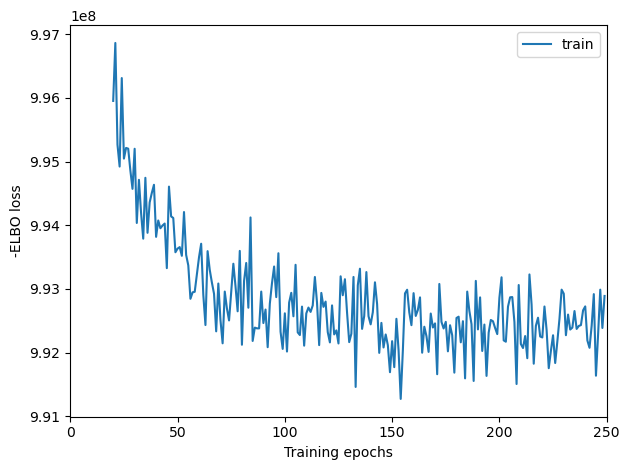

In [14]:
mod.plot_history(20)

In [15]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [02:37<00:00,  6.33it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/cell2location/pt1/reference_signatures/sc.h5ad'

In [16]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': False}
)

In [17]:
mod.plot_QC()

KeyError: 'post_sample_means'